# 4.1 - Binary Classification Example of IMDB Dataset

* [4.1.1 - The IMDB Dataset](#first-bullet)
* [4.1.2 - Preparing the Data](#second-bullet)
* [4.1.3 - Building Your Model](#third-bullet)
* [4.1.4 - Validating Your Approach](#fourth-bullet)
* [4.1.5 - Using a Trained Model to Generate Predictions on New Data](#fifth-bullet)
* [4.1.6 - Furthe Experiments](#sixth-bullet)

Use the pre-packaged Keras IMDB dataset to create a basic binary classifier.

## 4.1.1 - The IMDB Dataset <a class="anchor" id="first-bullet"></a>

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

Words have already been encoded to integers, and our labels are encoded as either 0 for a negative review, or 1 for a positive review

In [2]:
print(train_data[0])
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


Our index of words should not exceed 10,000 since we are only encoding the top 10,000 words.

In [3]:
print(max([max(sequence) for sequence in train_data]))

9999


Reviews can be translated back into their original text using the word index that was created for the IMDB reviews.  

The original word index is stored as a dictionary with the word as key, and integer as value `{'fawn': 34701, 'tsukino': 52006 ... }`.  These key-value pairs are reversed to make translation easier with the Python dictionary `get()`  method.

In [4]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

Why are we translating with `get(i - 3)` instead of `get(i)`?  The book does not really say, but the reason is in the documentation of the [tf.keras.datasets.imdb.get_word_index()](https://keras.io/api/datasets/imdb/#get_word_index-function) function.

Basically, values of 1, 2, and 3 in our encoded reviews are used to represent "padding", the start of a sequence, and any unknown or non-encoded word, respectively.   Our word index still starts at 1 (`{1:'the' ... }`, so everything is offset by 3 and needs to be corrected for our review to make any sense..



In [5]:
# Using .get(i, '?') instead of .get(i - 3, '?') produces gibberish.
gibberish_review = ' '.join(
    [reverse_word_index.get(i, '?') for i in train_data[0]])
print(gibberish_review)

the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have tw

## 4.1.2 - Preparing the Data <a class="anchor" id="second-bullet"></a>

First explore manually preparing the data using one-hot encoding.  The code below will one-hot encode our lists to turn them into vectors of 0s and 1s of length `dimension`.  In this example dimension is 10,000 since we encoded only the top 10,000 words in the step above.

The value at index i for each vector will be 1 if the encoded value is present in our sequence.  For example, if the word encoded by the number 9 is present in our original sequence, then i=9 of our vector will equal 1.

In [6]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Vectorize the test and training data for our model
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

## 4.1.3  Building Your Model <a class="anchor" id="third-bullet"></a>

Our inital model will have two `Dense` layers with 16 units that use the relu activation function, and one final Dense layer with 1 unit for our binary classification.

In [7]:
from tensorflow import keras

model = keras.Sequential([
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

We need an optimizer and loss function to compile our model.  Binary Crossentropy is used for our loss function because the output of our final layer is a probability between 0 and 1 and we are prediction two classes (positive or negative movie review).  RMSProp is used for our optimizer as an arbitrary starting point.

In [8]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 4.1.4 - Validating Your Approach <a class="anchor" id="fourth-bullet"></a>

Our data will be split into a test and train data set to evaluate our model performance.  High accuracy on our training data set and poor accuracy on our validation set indicates that we may be overfitting the model.

In [9]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 109ms/step - loss: 0.5240 - accuracy: 0.7982 - val_loss: 0.4053 - val_accuracy: 0.8667
Epoch 2/20
30/30 [==============================] - 1s 30ms/step - loss: 0.3221 - accuracy: 0.9023 - val_loss: 0.3191 - val_accuracy: 0.8816
Epoch 3/20
30/30 [==============================] - 1s 28ms/step - loss: 0.2360 - accuracy: 0.9257 - val_loss: 0.2815 - val_accuracy: 0.8921
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1839 - accuracy: 0.9406 - val_loss: 0.2725 - val_accuracy: 0.8906
Epoch 5/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1500 - accuracy: 0.9526 - val_loss: 0.2762 - val_accuracy: 0.8880
Epoch 6/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1224 - accuracy: 0.9625 - val_loss: 0.2895 - val_accuracy: 0.8866
Epoch 7/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1022 - accuracy: 0.9696 - val_loss: 0.3064 - val_accuracy: 0.8840
Epoch 8/20
3

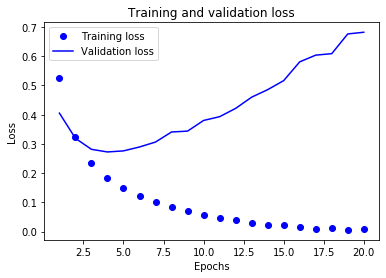

In [11]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

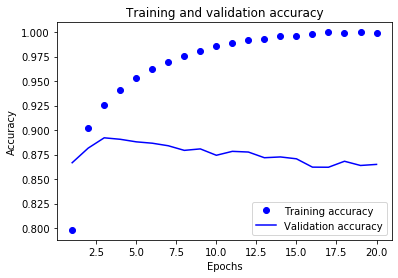

In [12]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Based on our graph of training and validation loss, we are likely overfitting our data to the training data.  This is indicated by a steady decrease of loss for our training data, but an increase in loss after approximately epoch 4 in our validation data set.  

Similarly, our model accuracy steadily increases on our training data, but has no increase in accuracy past epoch 4-5.  

Train the network with 4 epochs instead of 20.

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 1s 17ms/step - loss: 0.2291 - accuracy: 0.9460
Epoch 2/4
49/49 [==============================] - 1s 17ms/step - loss: 0.1367 - accuracy: 0.9601
Epoch 3/4
49/49 [==============================] - 1s 18ms/step - loss: 0.1077 - accuracy: 0.9675
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.4837 - accuracy: 0.8608


[0.48365893959999084, 0.86080002784729]

## 4.1.5 - Using a Trained Model to Generate Predictions on New Data <a class="anchor" id="fifth-bullet"></a>

We can get the probability of a review being positive by using the `predict` method of our model.

In [14]:
model.predict(x_test)

array([[0.01364282],
       [0.9999832 ],
       [0.47820464],
       ...,
       [0.0592548 ],
       [0.04946777],
       [0.81372494]], dtype=float32)

## 4.1.6 - Further Experiments <a class="anchor" id="fourth-bullet"></a>

Our original model used 32 units in our representation layers.  What would happen if we kept all other parameters the same as our first model, but increased the number of units to 128?

In [15]:
model = keras.Sequential([
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 82ms/step - loss: 0.4952 - accuracy: 0.7609 - val_loss: 0.3153 - val_accuracy: 0.8775
Epoch 2/20
30/30 [==============================] - 2s 52ms/step - loss: 0.2599 - accuracy: 0.8998 - val_loss: 0.2861 - val_accuracy: 0.8856
Epoch 3/20
30/30 [==============================] - 2s 50ms/step - loss: 0.1655 - accuracy: 0.9391 - val_loss: 0.2826 - val_accuracy: 0.8867
Epoch 4/20
30/30 [==============================] - 2s 54ms/step - loss: 0.1159 - accuracy: 0.9595 - val_loss: 0.3157 - val_accuracy: 0.8860
Epoch 5/20
30/30 [==============================] - 2s 50ms/step - loss: 0.0899 - accuracy: 0.9729 - val_loss: 0.3833 - val_accuracy: 0.8806
Epoch 6/20
30/30 [==============================] - 2s 58ms/step - loss: 0.0730 - accuracy: 0.9777 - val_loss: 0.3820 - val_accuracy: 0.8830
Epoch 7/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0150 - accuracy: 0.9975 - val_loss: 1.0203 - val_accuracy: 0.7982
Epoch 8/20
30

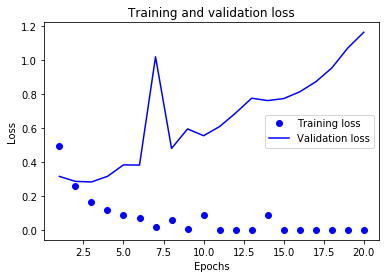

In [16]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

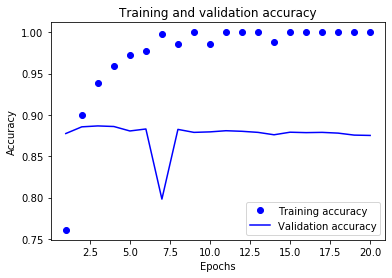

In [17]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Our results are somewhat similar to our network consisting of two representation layers of 32 units.  Our validation loss increases after about epoch 4, and our validation accuracy stops improving as well.

What about removing one of the representation layers?

In [18]:
model = keras.Sequential([
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 85ms/step - loss: 0.5108 - accuracy: 0.7947 - val_loss: 0.3996 - val_accuracy: 0.8674
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.3288 - accuracy: 0.8999 - val_loss: 0.3284 - val_accuracy: 0.8821
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.2544 - accuracy: 0.9221 - val_loss: 0.2939 - val_accuracy: 0.8909
Epoch 4/20
30/30 [==============================] - 1s 26ms/step - loss: 0.2080 - accuracy: 0.9367 - val_loss: 0.2841 - val_accuracy: 0.8880
Epoch 5/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1764 - accuracy: 0.9464 - val_loss: 0.2733 - val_accuracy: 0.8912
Epoch 6/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1526 - accuracy: 0.9529 - val_loss: 0.2749 - val_accuracy: 0.8890
Epoch 7/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1318 - accuracy: 0.9613 - val_loss: 0.2792 - val_accuracy: 0.8889
Epoch 8/20
30

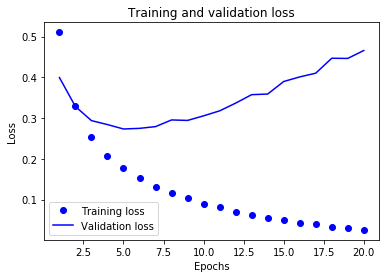

In [19]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

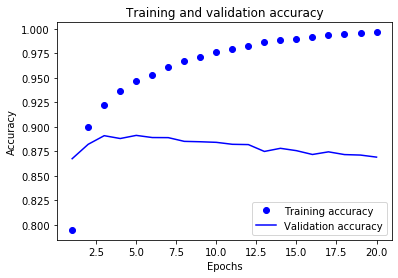

In [20]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It looks like we still overfit our model, but overfitting does not occur until about epoch 5 or 6.

Maybe a combination of fewer representation layers and fewer units?

In [21]:
model = keras.Sequential([
  keras.layers.Dense(8, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 140ms/step - loss: 0.5332 - accuracy: 0.7870 - val_loss: 0.4306 - val_accuracy: 0.8610
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.3621 - accuracy: 0.8951 - val_loss: 0.3531 - val_accuracy: 0.8795
Epoch 3/20
30/30 [==============================] - 1s 26ms/step - loss: 0.2859 - accuracy: 0.9137 - val_loss: 0.3123 - val_accuracy: 0.8862
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2389 - accuracy: 0.9280 - val_loss: 0.3034 - val_accuracy: 0.8805
Epoch 5/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2064 - accuracy: 0.9389 - val_loss: 0.2883 - val_accuracy: 0.8875
Epoch 6/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1822 - accuracy: 0.9461 - val_loss: 0.2749 - val_accuracy: 0.8910
Epoch 7/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1619 - accuracy: 0.9527 - val_loss: 0.2745 - val_accuracy: 0.8900
Epoch 8/20
3

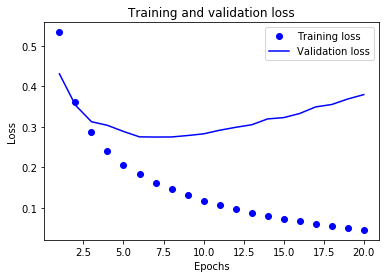

In [22]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

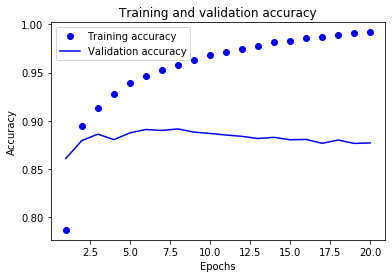

In [23]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems our current approach only delays the inevitable, decreasing the number of representational layers and units delays the epoch in which we see overfitting in our model, but we get no real improvement on how our model performs on or validation data set.